In [226]:
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

from scipy.stats import norm
from matplotlib.ticker import PercentFormatter
import scipy.stats

# Part 1: Basic Analysis of Bitcoin's historical performance

### Simple Descriptive Statistics, Annualized Returns, Volatility, and Normality Check

In [227]:
# We create the Ticker object for BTC-USD and then import the time-series using the module yfinance
btc = yf.Ticker("BTC-USD")
btc_hist = btc.history(period = "10y")

btc_close = btc_hist["Close"]

In [228]:
btc_close.head()

Date
2015-01-23 00:00:00+00:00    232.878998
2015-01-24 00:00:00+00:00    247.847000
2015-01-25 00:00:00+00:00    253.718002
2015-01-26 00:00:00+00:00    273.472992
2015-01-27 00:00:00+00:00    263.475006
Name: Close, dtype: float64

In [229]:
# Some descriptive statistics
btc_close.describe().iloc[1:]

mean     20759.256624
std      23000.796626
min        210.494995
25%       2769.067444
50%       9812.498047
75%      33785.009766
max     106146.265625
Name: Close, dtype: float64

In [230]:
btc_returns_10y = btc_close.pct_change().dropna()

print("The total % returns we'd have made from BTC if we'd invested 10 years ago are:", 
      np.round((((btc_returns_10y+1).prod()-1)*100),2))

print("The % standard deviations for daily returns is:", np.round(np.std(btc_returns_10y),2)*100)

The total % returns we'd have made from BTC if we'd invested 10 years ago are: 45342.46
The % standard deviations for daily returns is: 4.0


In [231]:
annualized_returns = np.power(btc_close.iloc[-1]/btc_close.iloc[0], 1/10)-1

print("The annualized returns for BTC-USD, are:", annualized_returns)

The annualized returns for BTC-USD, are: 0.8439374299068774


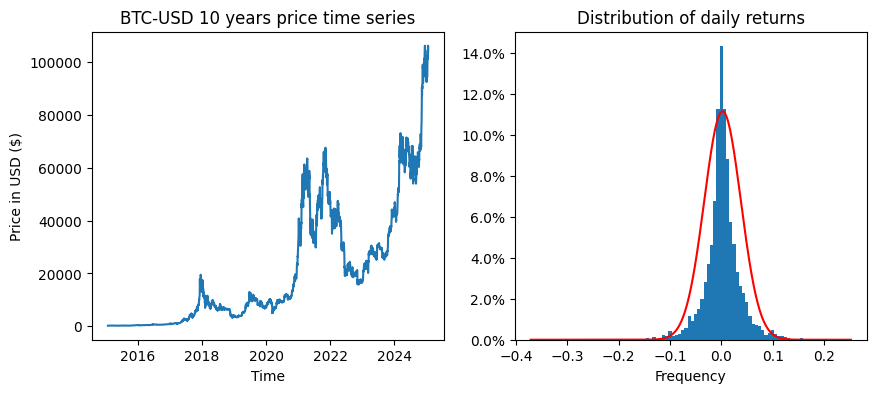

In [232]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) 

# Plot the first graph
ax1.plot(btc_close.index, btc_close.values)
ax1.set_title("BTC-USD 10 years price time series")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price in USD ($)")

# Plot the second graph
len_btc_ret = len(btc_returns_10y)
weights = np.ones(len_btc_ret)/len_btc_ret*100

ax2.hist(btc_returns_10y, bins = 100, weights = weights )
ax2.set_title("Distribution of daily returns")
ax2.set_xlabel("Frequency")
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=100)) 

"""
We overlap a gaussian distribution over the second graph to visually see how the distribution of returns
compares to a Gaussian.
"""
mu, std = norm.fit(btc_returns_10y)
x_axis_values = np.linspace(min(btc_returns_10y), max(btc_returns_10y), 1000)

pdf = norm.pdf(x_axis_values, mu, std)

ax2.plot(x_axis_values, pdf, "r-", label = "Gaussian Fit")

# Show the plot
plt.show()

In [233]:
# Let's also perform the Jarque-Bera test to check if returns are normally distributed

jb_stats, p_value = scipy.stats.jarque_bera(btc_returns_10y)

print(f"Jarque-Bera statistic: {jb_stats}")
print(f"p-value: {p_value}")

Jarque-Bera statistic: 8767.283290792093
p-value: 0.0


From Jarque-Bera's test there seems to be sufficient evidence that returns are not normally distributed.
To get a deeper insight, let's look at the skewnees and at the kurtosis of the data.

In [234]:
# Calculate skewness
skewness_value = scipy.stats.skew(btc_returns_10y)

# Calculate kurtosis (Fisher's definition)
kurtosis_value = scipy.stats.kurtosis(btc_returns_10y) 

print(f"Skewness: {skewness_value}")
print(f"Kurtosis: {kurtosis_value}")

Skewness: -0.09031109232454458
Kurtosis: 7.5873528217770705


While the distribution seems to be centered, like the Gaussian distribution, it's evident that the tails are fatter than the normal distribution.

### Downside Analysis: Drawdown, VaR, Semideviation

In [235]:
# We defined a welath index with a starting capital of 1000 euros
wealth_index_btc = 1000*(1+btc_returns_10y).cumprod()
previous_peaks_btc = wealth_index_btc.cummax()

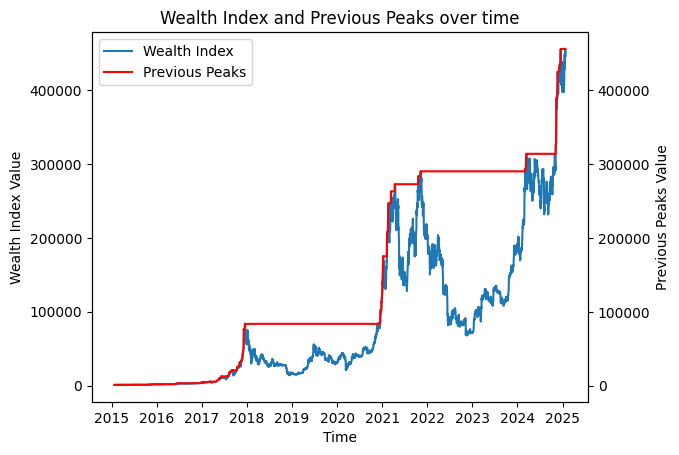

In [236]:
fig, ax = plt.subplots()

# First of all, we create a plot with a secondary y-axis
ax.plot(wealth_index_btc, label="Wealth Index") 
ax2 = ax.twinx() 
ax2.plot(previous_peaks_btc, color="r", label="Previous Peaks") 

# We set the labels for our plot
ax.set_xlabel("Time")
ax.set_ylabel("Wealth Index Value")
ax2.set_ylabel("Previous Peaks Value")
plt.title("Wealth Index and Previous Peaks over time")

# We unite the two legends into one
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left') 

plt.show()

<Axes: xlabel='Date'>

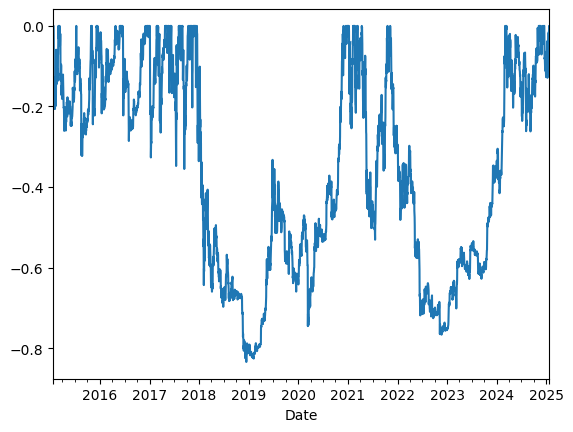

In [241]:
# We plot the drawdowns for the wealth index over time
drawdown_btc = (wealth_index_btc - previous_peaks_btc)/previous_peaks_btc
drawdown_btc.plot()

In [245]:
# Let's identify the maximum drawdown, and let's index when it happened

print(f"The maximum drawdown was: {round(drawdown_btc.min(),2)}, which happened on {drawdown_btc.idxmin().strftime('%Y-%m-%d')}")

The maximum drawdown was: -0.83, which happened on 2018-12-15


In [261]:
# Now, let's calculate the semideviation of Bitcoin's returns by using a Boolean mask

print("Bitcoin's semideviation (for daily returns) is:", round(np.std(btc_returns_10y[btc_returns_10y<0],ddof=0),2))

Bitcoin's semideviation (for daily returns) is: 0.03


In [273]:
# Let's identify the daily VaR using the Historical Simulation Method

# We define the confidence level
alpha = 0.05

# We calculate the Historical VaR (daily frequency)
historical_var = np.quantile(btc_returns_10y.sort_values(), q= alpha)

# Let's assume a portfolio value of 1000 USD all invested in BTC-USD to estimate the VaR in monetary terms
portfolio_value = 1000

# We calculate the VaR in monetary terms
var_monetary = portfolio_value * historical_var 

print("The daily VaR in monetary terms, based on historical values is:", round(var_monetary,2))


The daily VaR in monetary terms, based on historical values is: -54.42


In [284]:
# Now, let's try a different approach: let's calculate the VaR with bootstrap

# Confidence Level
alpha = 0.05
# Wealth/Portfolio Value
portfolio_value = 1000

num_boostraps = 10000

var_estimates = np.zeros(num_boostraps)

for i in range(num_boostraps):
    # Resample with replacement
    bootstrap_sample = np.random.choice(btc_returns_10y, size = round(len(btc_returns_10y)/2), replace= True)
    var_estimates[i]=np.quantile(bootstrap_sample, alpha)

var_monetary = portfolio_value*var_estimates

print(f"Mean Bootstrap VaR: ${np.mean(var_monetary):.2f}") 
print(f"VaR at {(1-alpha)*100}% confidence level: ${np.quantile(var_monetary, (1-alpha)):.2f}") 

Mean Bootstrap VaR: $-54.44
VaR at 95.0% confidence level: $-49.87
